In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout,BatchNormalization,Activation
from tensorflow.keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   shear_range=0.4,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   rotation_range=45,
                                   fill_mode='nearest')

In [7]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/train/', 
                                                    batch_size=32, 
                                                    target_size=(120,120), 
                                                    class_mode='categorical',
                                                    shuffle=True, 
                                                    seed = 42, 
                                                    color_mode = 'rgb')

Found 19674 images belonging to 2 classes.


In [10]:
test_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/test/', 
                                                   batch_size=32, 
                                                   target_size=(120,120), 
                                                   class_mode='categorical',
                                                   shuffle=False, 
                                                   seed = 42, 
                                                   color_mode = 'rgb')


Found 2158 images belonging to 2 classes.


In [11]:
valid_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/valid/', 
                                                    batch_size=32, 
                                                    target_size=(120,120), 
                                                    class_mode='categorical',
                                                    shuffle=True, 
                                                    seed = 42, 
                                                    color_mode = 'rgb')

Found 2162 images belonging to 2 classes.


In [9]:
x, y = next(train_generator)
print(f"Shape of batch (X): {x.shape}")
print(f"Shape of labels (Y): {y.shape}")


Shape of batch (X): (32, 120, 120, 3)
Shape of labels (Y): (32, 2)


In [17]:
base_Neural_Net = VGG19(input_shape=(120,120, 3), weights='imagenet', include_top=False)

# Create a Sequential model
model = Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Freeze the base model layers
for layer in base_Neural_Net.layers:
    layer.trainable = False

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),  # Smaller learning rate for transfer learning
    metrics=['accuracy', 'AUC']
)

model.build((None, 120,120, 3))
# Print the model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 3, 3, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 4608)                │          18,432 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,224,258 (80.96 MB)

 Trainable params: 1,190,146 (4.54 MB)

 Non-trainable params: 20,034,112 (76.42 MB)

In [18]:
filepath='model_vgg19.keras'
cp = ModelCheckpoint(filepath, monitor='val_accuracy', verbose = 1, save_best_only=True, save_weights_only=False, mode='max',save_freq='epoch')

In [19]:
EPOCHS = 10
est = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=15
)

history_01 = model.fit(
    train_generator,
    batch_size=32,
    epochs=EPOCHS,
    steps_per_epoch=60,
    validation_data=valid_generator,
    callbacks=[est,cp]
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - AUC: 0.6015 - accuracy: 0.5683 - loss: 0.8835
Epoch 1: val_accuracy improved from -inf to 0.75347, saving model to model_vgg19.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - AUC: 0.6030 - accuracy: 0.5694 - loss: 0.8815 - val_AUC: 0.8360 - val_accuracy: 0.7535 - val_loss: 0.5343
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - AUC: 0.8278 - accuracy: 0.7484 - loss: 0.5395
Epoch 2: val_accuracy improved from 0.75347 to 0.79001, saving model to model_vgg19.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - AUC: 0.8279 - accuracy: 0.7485 - loss: 0.5393 - val_AUC: 0.8688 - val_accuracy: 0.7900 - val_loss: 0.4794
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - AUC: 0.8422 - accuracy: 0.7679 - loss: 0.5386
Epoch 3: val_accuracy improved from 0.79001 to 0.81730, saving model to model_vgg19.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - AUC: 0.8424 - accuracy: 0.7680 - loss: 0.5380 - val_AUC: 0.9010 - val_accuracy: 0.8173 - val_loss:

In [20]:
def plot_metrics(history):
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

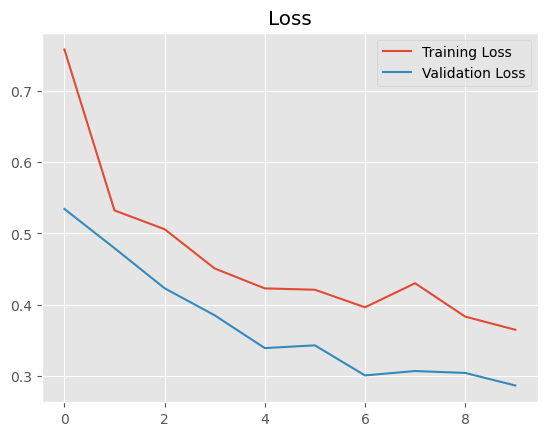

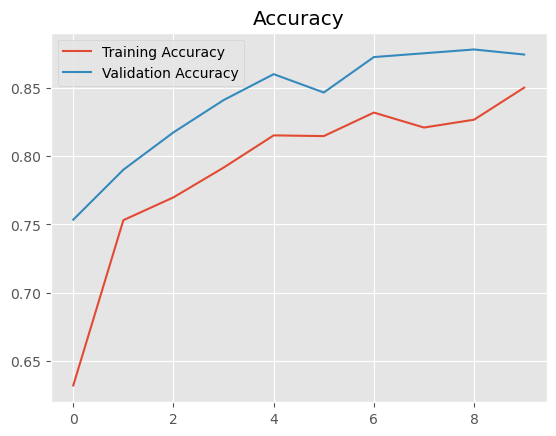

In [21]:
plot_metrics(history_01) 

In [22]:
from tensorflow.keras.models import Model, load_model
best_model_1=load_model("model_vgg19.keras")
best_model_1.metrics_names

['loss', 'compile_metrics']

In [23]:
metrics = best_model_1.evaluate(test_generator)
loss = metrics[0]
accuracy = metrics[1]
auc = metrics[2]

print(f'Loss: {loss}, Accuracy: {accuracy}, AUC: {auc}')

68/68 ━━━━━━━━━━━━━━━━━━━━ 47s 681ms/step - AUC: 0.9430 - accuracy: 0.8646 - loss: 0.3055
Loss: 0.3016984760761261, Accuracy: 0.8697868585586548, AUC: 0.9441806077957153


In [24]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {accuracy}")

Test Loss = 0.3016984760761261
Test Accuracy = 0.8697868585586548


In [36]:
base_Neural_Net = VGG19(input_shape=(120,120, 3), weights='imagenet', include_top=False)

# Unfreeze the last few layers for fine-tuning
set_trainable = False

for layer in base_Neural_Net.layers:
    if layer.name.startswith('block5'):  # Unfreeze all block5 layers
        layer.trainable = True
    else:
        layer.trainable = False

# Create a Sequential model
model = Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-5),  # Smaller learning rate for transfer learning
    metrics=['accuracy', 'AUC']
)

model.build((None, 120,120, 3))
# Print the model summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 3, 3, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 4608)                │          18,432 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,224,258 (80.96 MB)

 Trainable params: 10,629,378 (40.55 MB)

 Non-trainable params: 10,594,880 (40.42 MB)

In [37]:
EPOCHS = 15
est = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=15
)

history_01 = model.fit(
    train_generator,
    batch_size=32,
    epochs=EPOCHS,
    steps_per_epoch=60,
    validation_data=valid_generator,
    callbacks=[est,cp]
)

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - AUC: 0.5620 - accuracy: 0.5587 - loss: 0.9848
Epoch 1: val_accuracy did not improve from 0.92044
60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - AUC: 0.5629 - accuracy: 0.5591 - loss: 0.9830 - val_AUC: 0.7610 - val_accuracy: 0.6924 - val_loss: 0.6088
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - AUC: 0.7293 - accuracy: 0.6638 - loss: 0.6886
Epoch 2: val_accuracy did not improve from 0.92044
60/60 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - AUC: 0.7296 - accuracy: 0.6641 - loss: 0.6885 - val_AUC: 0.8614 - val_accuracy: 0.7831 - val_loss: 0.5140
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - AUC: 0.7864 - accuracy: 0.7017 - loss: 0.6207
Epoch 3: val_accuracy did not improve from 0.92044
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - AUC: 0.7869 - accuracy: 0.7021 - loss: 0.6199 - val_AUC: 0.9179 - val_accuracy: 0.8386 - val_loss: 0.4175
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - AUC: 0.8492 - accuracy: 0.7672 - loss: 0.5043
Epoch

C:\Users\abhi2\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 11: val_accuracy improved from 0.92137 to 0.92553, saving model to model_vgg19.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - AUC: 0.9517 - accuracy: 0.8884 - loss: 0.2841 - val_AUC: 0.9805 - val_accuracy: 0.9255 - val_loss: 0.1797
Epoch 12/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - AUC: 0.9733 - accuracy: 0.9137 - loss: 0.2090
Epoch 12: val_accuracy improved from 0.92553 to 0.92738, saving model to model_vgg19.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - AUC: 0.9732 - accuracy: 0.9134 - loss: 0.2094 - val_AUC: 0.9801 - val_accuracy: 0.9274 - val_loss: 0.1776
Epoch 13/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - AUC: 0.9721 - accuracy: 0.9211 - loss: 0.2151
Epoch 13: val_accuracy did not improve from 0.92738
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - AUC: 0.9721 - accuracy: 0.9210 - loss: 0.2152 - val_AUC: 0.9777 - val_accuracy: 0.9209 - val_loss: 0.1909
Epoch 14/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - AUC: 0.9745 - accuracy: 0.9097 - loss: 0.2064
Epoch 14: val_accurac

In [38]:
def plot_metrics(history):
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

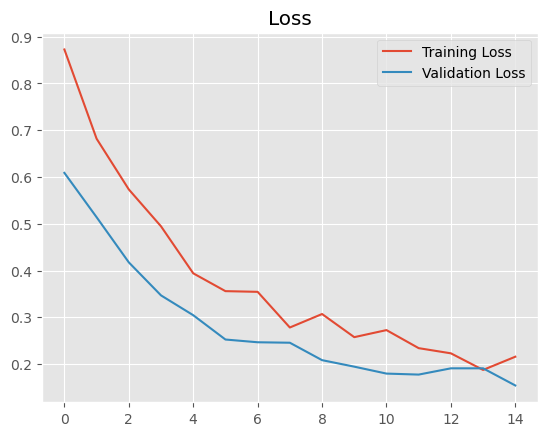

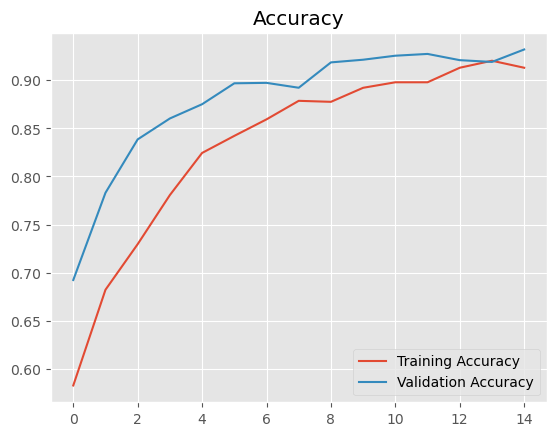

In [39]:
plot_metrics(history_01) 

In [12]:
from tensorflow.keras.models import Model, load_model
best_model_1=load_model("model_vgg19.keras")
best_model_1.metrics_names

['loss', 'compile_metrics']

In [13]:
metrics = best_model_1.evaluate(test_generator)
loss = metrics[0]
accuracy = metrics[1]
auc = metrics[2]

print(f'Loss: {loss}, Accuracy: {accuracy}, AUC: {auc}')

C:\Users\abhi2\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 773ms/step - AUC: 0.9905 - accuracy: 0.9546 - loss: 0.1218
Loss: 0.16197292506694794, Accuracy: 0.9337349534034729, AUC: 0.9835237264633179


In [14]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {accuracy}")

Test Loss = 0.16197292506694794
Test Accuracy = 0.9337349534034729


In [15]:
nb_samples = test_generator.samples

In [16]:
print("True labels shape:", test_generator.classes.shape)
print("Unique true labels:", np.unique(test_generator.classes))

True labels shape: (2158,)
Unique true labels: [0 1]


In [18]:
predicted_probabilities = best_model_1.predict(test_generator)[:, 1]

# Set a custom threshold
threshold = 0.5  # Change this value to experiment
adjusted_predictions = (predicted_probabilities >= threshold).astype(int)

# Generate the confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_generator.classes, adjusted_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Calculate accuracy, precision, recall, and F1-score
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, adjusted_predictions))

68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 766ms/step
Confusion Matrix:
 [[1047   32]
 [ 111  968]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      1079
           1       0.97      0.90      0.93      1079

    accuracy                           0.93      2158
   macro avg       0.94      0.93      0.93      2158
weighted avg       0.94      0.93      0.93      2158

